In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
style.use('fivethirtyeight')
from tensorflow.keras import layers

In [2]:
directory_url='https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names=['cowper.txt', 'derby.txt', 'butler.txt']

In [3]:
for name in file_names:
    text_dir=tf.keras.utils.get_file(name,origin=directory_url+name)

In [4]:
parent_dir=os.path.dirname(text_dir)
parent_dir

'C:\\Users\\personal\\.keras\\datasets'

In [5]:
def labeler(example,index):
    return example,tf.cast(index,tf.int64)

In [6]:
labeled_data_sets=[]
for i,filename in enumerate(file_names):
    lines_dataset=tf.data.TextLineDataset(os.path.join(parent_dir,filename))
    print(lines_dataset)
    labeled_dataset=lines_dataset.map(lambda ex:labeler(ex,i))
    labeled_data_sets.append(labeled_dataset)

<TextLineDatasetV2 shapes: (), types: tf.string>
<TextLineDatasetV2 shapes: (), types: tf.string>
<TextLineDatasetV2 shapes: (), types: tf.string>


In [7]:
labeled_data_sets

[<MapDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 <MapDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 <MapDataset shapes: ((), ()), types: (tf.string, tf.int64)>]

In [8]:
buffer_size=50000
batch_size=64
take_size=5000

In [9]:
all_labeled_data=labeled_data_sets[0]
for dataset in labeled_data_sets[1:]:
    all_labeled_data=all_labeled_data.concatenate(dataset)

In [10]:
all_labeled_data

<ConcatenateDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [11]:
all_labeled_data=all_labeled_data.shuffle(buffer_size=buffer_size,
                                         reshuffle_each_iteration=False)

In [12]:
for example in all_labeled_data.take(5):
    print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b'but are stopped by Jupiter, who reascends from Ida, and in heaven'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'array, and went about everywhere effecting the exchanges of armour; the'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'the ships. Little did they know that at the gates they should find two'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(), dtype=string, numpy=b"Along the public road, until they reach'd">, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'tripod full of bath water on to a clear fire: they threw sticks on to'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)


In [13]:
tokenizer = tfds.deprecated.text.Tokenizer()
vocabulary_set=set()
for text_tensor,_ in all_labeled_data:
    some_tokens=tokenizer.tokenize(text_tensor.numpy())
    vocabulary_set.update(some_tokens)
vocabulary_size=len(vocabulary_set)
vocabulary_size

17178

In [14]:
encoder=tfds.deprecated.text.TokenTextEncoder(vocabulary_set)

In [15]:
example_text=next(iter(all_labeled_data))[0].numpy()
example_text

b'but are stopped by Jupiter, who reascends from Ida, and in heaven'

In [16]:
encoded_example=encoder.encode(example_text)
encoded_example

[16261, 1964, 8567, 11474, 14892, 6673, 11864, 11188, 7411, 8896, 10596, 12280]

In [17]:
def encode(text_tensor,label):
    encoded_text=encoder.encode(text_tensor.numpy())
    return encoded_text,label

In [18]:
def encode_map_func(text,label):
    encoded_text,label=tf.py_function(encode,
                                     inp=[text,label],
                                     Tout=(tf.int64,tf.int64))
    encoded_text.set_shape([None])
    label.set_shape([])
    return encoded_text,label

In [19]:
all_encoded_data=all_labeled_data.map(encode_map_func)

In [20]:
next(iter(all_encoded_data))[0].numpy()

array([16261,  1964,  8567, 11474, 14892,  6673, 11864, 11188,  7411,
        8896, 10596, 12280], dtype=int64)

In [21]:
train_data=all_encoded_data.skip(take_size).shuffle(batch_size)
train_data=train_data.padded_batch(batch_size)

In [22]:
test_data=all_encoded_data.take(take_size)
test_data=test_data.padded_batch(batch_size)

In [23]:
sample_text,sample_label=next(iter(test_data))
sample_text[0],sample_label[0]

(<tf.Tensor: shape=(15,), dtype=int64, numpy=
 array([16261,  1964,  8567, 11474, 14892,  6673, 11864, 11188,  7411,
         8896, 10596, 12280,     0,     0,     0], dtype=int64)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [24]:
vocabulary_size +=1

In [34]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocabulary_size,64))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
for units in [64,64]:
    model.add(tf.keras.layers.Dense(units,activation='relu'))
model.add(tf.keras.layers.Dense(3))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1099456   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 1,178,115
Trainable params: 1,178,115
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.fit(train_data,
         validation_data=test_data,
         epochs=10)

Epoch 1/10


    345/Unknown - 0s 0s/step - loss: 1.1033 - accuracy: 0.20 - 0s 24ms/step - loss: 1.0980 - accuracy: 0.40 - 0s 27ms/step - loss: 1.0955 - accuracy: 0.40 - 0s 27ms/step - loss: 1.0925 - accuracy: 0.39 - 0s 28ms/step - loss: 1.0908 - accuracy: 0.38 - 0s 28ms/step - loss: 1.0876 - accuracy: 0.38 - 0s 28ms/step - loss: 1.0846 - accuracy: 0.37 - 0s 29ms/step - loss: 1.0798 - accuracy: 0.37 - 0s 29ms/step - loss: 1.0723 - accuracy: 0.38 - 1s 29ms/step - loss: 1.0645 - accuracy: 0.38 - 1s 29ms/step - loss: 1.0575 - accuracy: 0.38 - 1s 29ms/step - loss: 1.0466 - accuracy: 0.39 - 1s 29ms/step - loss: 1.0340 - accuracy: 0.39 - 1s 30ms/step - loss: 1.0225 - accuracy: 0.41 - 1s 30ms/step - loss: 1.0055 - accuracy: 0.43 - 1s 30ms/step - loss: 0.9998 - accuracy: 0.44 - 1s 30ms/step - loss: 0.9853 - accuracy: 0.45 - 1s 31ms/step - loss: 0.9732 - accuracy: 0.46 - 1s 31ms/step - loss: 0.9587 - accuracy: 0.47 - 1s 31ms/step - loss: 0.9520 - accuracy: 0.48 - 1s 31ms/step - loss: 0.9394 - accuracy: 0.49

    660/Unknown - 11s 31ms/step - loss: 0.6109 - accuracy: 0.693 - 11s 31ms/step - loss: 0.6099 - accuracy: 0.693 - 11s 31ms/step - loss: 0.6091 - accuracy: 0.694 - 11s 31ms/step - loss: 0.6082 - accuracy: 0.694 - 11s 31ms/step - loss: 0.6074 - accuracy: 0.695 - 11s 31ms/step - loss: 0.6071 - accuracy: 0.695 - 11s 31ms/step - loss: 0.6063 - accuracy: 0.695 - 11s 31ms/step - loss: 0.6055 - accuracy: 0.696 - 11s 31ms/step - loss: 0.6048 - accuracy: 0.697 - 11s 31ms/step - loss: 0.6036 - accuracy: 0.697 - 11s 31ms/step - loss: 0.6030 - accuracy: 0.698 - 11s 31ms/step - loss: 0.6021 - accuracy: 0.698 - 12s 31ms/step - loss: 0.6021 - accuracy: 0.699 - 12s 31ms/step - loss: 0.6014 - accuracy: 0.699 - 12s 31ms/step - loss: 0.6003 - accuracy: 0.699 - 12s 31ms/step - loss: 0.5995 - accuracy: 0.700 - 12s 31ms/step - loss: 0.5991 - accuracy: 0.700 - 12s 31ms/step - loss: 0.5987 - accuracy: 0.701 - 12s 31ms/step - loss: 0.5978 - accuracy: 0.701 - 12s 31ms/step - loss: 0.5968 - accuracy: 0.702 - 12

697/697 [==============================]0.5282 - accuracy: 0.744 - 23s 35ms/step - loss: 0.5278 - accuracy: 0.744 - 23s 35ms/step - loss: 0.5273 - accuracy: 0.744 - 23s 35ms/step - loss: 0.5267 - accuracy: 0.744 - 23s 35ms/step - loss: 0.5264 - accuracy: 0.745 - 23s 35ms/step - loss: 0.5259 - accuracy: 0.745 - 23s 35ms/step - loss: 0.5255 - accuracy: 0.745 - 24s 35ms/step - loss: 0.5250 - accuracy: 0.745 - 24s 35ms/step - loss: 0.5246 - accuracy: 0.746 - 24s 35ms/step - loss: 0.5239 - accuracy: 0.746 - 24s 35ms/step - loss: 0.5236 - accuracy: 0.746 - 24s 35ms/step - loss: 0.5234 - accuracy: 0.746 - 24s 35ms/step - loss: 0.5227 - accuracy: 0.747 - 24s 35ms/step - loss: 0.5227 - accuracy: 0.747 - 24s 35ms/step - loss: 0.5224 - accuracy: 0.747 - 24s 35ms/step - loss: 0.5219 - accuracy: 0.747 - 24s 35ms/step - loss: 0.5215 - accuracy: 0.748 - 24s 35ms/step - loss: 0.5209 - accuracy: 0.748 - 27s 39ms/step - loss: 0.5207 - accuracy: 0.7484 - val_loss: 0.3949 - val_accuracy: 0.8238
Epoch 2/10

365/697 [==============>...............] - ETA: 0s - loss: 0.5002 - accuracy: 0.79 - ETA: 16s - loss: 0.4903 - accuracy: 0.750 - ETA: 20s - loss: 0.4857 - accuracy: 0.765 - ETA: 21s - loss: 0.4878 - accuracy: 0.758 - ETA: 22s - loss: 0.4436 - accuracy: 0.789 - ETA: 23s - loss: 0.4344 - accuracy: 0.795 - ETA: 23s - loss: 0.4229 - accuracy: 0.805 - ETA: 23s - loss: 0.4203 - accuracy: 0.805 - ETA: 24s - loss: 0.4186 - accuracy: 0.807 - ETA: 24s - loss: 0.4161 - accuracy: 0.808 - ETA: 24s - loss: 0.4141 - accuracy: 0.812 - ETA: 25s - loss: 0.4070 - accuracy: 0.817 - ETA: 25s - loss: 0.4076 - accuracy: 0.815 - ETA: 25s - loss: 0.4036 - accuracy: 0.818 - ETA: 25s - loss: 0.3985 - accuracy: 0.820 - ETA: 25s - loss: 0.3957 - accuracy: 0.821 - ETA: 24s - loss: 0.3918 - accuracy: 0.823 - ETA: 24s - loss: 0.3946 - accuracy: 0.820 - ETA: 24s - loss: 0.3934 - accuracy: 0.820 - ETA: 24s - loss: 0.3963 - accuracy: 0.820 - ETA: 24s - loss: 0.3949 - accuracy: 0.821 - ETA: 24s - loss: 0.3915 - accuracy:

697/697 [==============================] - ETA: 12s - loss: 0.3228 - accuracy: 0.857 - ETA: 12s - loss: 0.3226 - accuracy: 0.857 - ETA: 12s - loss: 0.3227 - accuracy: 0.857 - ETA: 12s - loss: 0.3227 - accuracy: 0.858 - ETA: 12s - loss: 0.3225 - accuracy: 0.858 - ETA: 12s - loss: 0.3219 - accuracy: 0.858 - ETA: 12s - loss: 0.3219 - accuracy: 0.858 - ETA: 12s - loss: 0.3216 - accuracy: 0.858 - ETA: 12s - loss: 0.3221 - accuracy: 0.858 - ETA: 12s - loss: 0.3218 - accuracy: 0.858 - ETA: 12s - loss: 0.3213 - accuracy: 0.859 - ETA: 12s - loss: 0.3211 - accuracy: 0.859 - ETA: 11s - loss: 0.3209 - accuracy: 0.859 - ETA: 11s - loss: 0.3206 - accuracy: 0.859 - ETA: 11s - loss: 0.3202 - accuracy: 0.859 - ETA: 11s - loss: 0.3195 - accuracy: 0.859 - ETA: 11s - loss: 0.3197 - accuracy: 0.859 - ETA: 11s - loss: 0.3201 - accuracy: 0.859 - ETA: 11s - loss: 0.3200 - accuracy: 0.859 - ETA: 11s - loss: 0.3195 - accuracy: 0.859 - ETA: 11s - loss: 0.3196 - accuracy: 0.859 - ETA: 11s - loss: 0.3193 - accurac

370/697 [==============>...............] - ETA: 0s - loss: 0.2777 - accuracy: 0.82 - ETA: 15s - loss: 0.2633 - accuracy: 0.864 - ETA: 19s - loss: 0.2927 - accuracy: 0.871 - ETA: 21s - loss: 0.2903 - accuracy: 0.872 - ETA: 22s - loss: 0.2825 - accuracy: 0.880 - ETA: 23s - loss: 0.2832 - accuracy: 0.879 - ETA: 23s - loss: 0.2859 - accuracy: 0.876 - ETA: 24s - loss: 0.2819 - accuracy: 0.876 - ETA: 24s - loss: 0.2817 - accuracy: 0.877 - ETA: 24s - loss: 0.2899 - accuracy: 0.877 - ETA: 24s - loss: 0.2878 - accuracy: 0.878 - ETA: 24s - loss: 0.2845 - accuracy: 0.877 - ETA: 24s - loss: 0.2869 - accuracy: 0.871 - ETA: 24s - loss: 0.2790 - accuracy: 0.875 - ETA: 24s - loss: 0.2779 - accuracy: 0.877 - ETA: 24s - loss: 0.2779 - accuracy: 0.878 - ETA: 24s - loss: 0.2712 - accuracy: 0.880 - ETA: 24s - loss: 0.2766 - accuracy: 0.879 - ETA: 24s - loss: 0.2761 - accuracy: 0.879 - ETA: 24s - loss: 0.2762 - accuracy: 0.879 - ETA: 24s - loss: 0.2804 - accuracy: 0.878 - ETA: 24s - loss: 0.2781 - accuracy:

697/697 [==============================] - ETA: 12s - loss: 0.2402 - accuracy: 0.895 - ETA: 12s - loss: 0.2402 - accuracy: 0.895 - ETA: 12s - loss: 0.2400 - accuracy: 0.896 - ETA: 12s - loss: 0.2397 - accuracy: 0.896 - ETA: 12s - loss: 0.2398 - accuracy: 0.896 - ETA: 12s - loss: 0.2395 - accuracy: 0.896 - ETA: 12s - loss: 0.2396 - accuracy: 0.896 - ETA: 11s - loss: 0.2393 - accuracy: 0.896 - ETA: 11s - loss: 0.2389 - accuracy: 0.896 - ETA: 11s - loss: 0.2388 - accuracy: 0.896 - ETA: 11s - loss: 0.2384 - accuracy: 0.897 - ETA: 11s - loss: 0.2382 - accuracy: 0.897 - ETA: 11s - loss: 0.2380 - accuracy: 0.897 - ETA: 11s - loss: 0.2382 - accuracy: 0.897 - ETA: 11s - loss: 0.2383 - accuracy: 0.897 - ETA: 11s - loss: 0.2382 - accuracy: 0.897 - ETA: 11s - loss: 0.2380 - accuracy: 0.897 - ETA: 11s - loss: 0.2375 - accuracy: 0.897 - ETA: 11s - loss: 0.2376 - accuracy: 0.897 - ETA: 11s - loss: 0.2371 - accuracy: 0.897 - ETA: 10s - loss: 0.2376 - accuracy: 0.897 - ETA: 10s - loss: 0.2377 - accurac

370/697 [==============>...............] - ETA: 0s - loss: 0.3656 - accuracy: 0.82 - ETA: 16s - loss: 0.2395 - accuracy: 0.885 - ETA: 19s - loss: 0.2638 - accuracy: 0.893 - ETA: 21s - loss: 0.2375 - accuracy: 0.904 - ETA: 22s - loss: 0.2205 - accuracy: 0.911 - ETA: 22s - loss: 0.2172 - accuracy: 0.911 - ETA: 23s - loss: 0.2250 - accuracy: 0.903 - ETA: 24s - loss: 0.2226 - accuracy: 0.906 - ETA: 24s - loss: 0.2165 - accuracy: 0.909 - ETA: 24s - loss: 0.2215 - accuracy: 0.907 - ETA: 24s - loss: 0.2270 - accuracy: 0.904 - ETA: 24s - loss: 0.2243 - accuracy: 0.906 - ETA: 24s - loss: 0.2208 - accuracy: 0.909 - ETA: 24s - loss: 0.2147 - accuracy: 0.912 - ETA: 24s - loss: 0.2082 - accuracy: 0.915 - ETA: 24s - loss: 0.2134 - accuracy: 0.914 - ETA: 24s - loss: 0.2138 - accuracy: 0.913 - ETA: 24s - loss: 0.2210 - accuracy: 0.910 - ETA: 24s - loss: 0.2204 - accuracy: 0.910 - ETA: 24s - loss: 0.2219 - accuracy: 0.910 - ETA: 24s - loss: 0.2204 - accuracy: 0.911 - ETA: 24s - loss: 0.2209 - accuracy:

697/697 [==============================] - ETA: 12s - loss: 0.1815 - accuracy: 0.924 - ETA: 12s - loss: 0.1815 - accuracy: 0.924 - ETA: 12s - loss: 0.1813 - accuracy: 0.924 - ETA: 12s - loss: 0.1813 - accuracy: 0.924 - ETA: 12s - loss: 0.1813 - accuracy: 0.924 - ETA: 11s - loss: 0.1813 - accuracy: 0.924 - ETA: 11s - loss: 0.1814 - accuracy: 0.924 - ETA: 11s - loss: 0.1811 - accuracy: 0.925 - ETA: 11s - loss: 0.1810 - accuracy: 0.925 - ETA: 11s - loss: 0.1806 - accuracy: 0.925 - ETA: 11s - loss: 0.1804 - accuracy: 0.925 - ETA: 11s - loss: 0.1802 - accuracy: 0.925 - ETA: 11s - loss: 0.1800 - accuracy: 0.925 - ETA: 11s - loss: 0.1804 - accuracy: 0.925 - ETA: 11s - loss: 0.1804 - accuracy: 0.925 - ETA: 11s - loss: 0.1804 - accuracy: 0.925 - ETA: 11s - loss: 0.1801 - accuracy: 0.925 - ETA: 11s - loss: 0.1800 - accuracy: 0.925 - ETA: 10s - loss: 0.1798 - accuracy: 0.925 - ETA: 10s - loss: 0.1798 - accuracy: 0.925 - ETA: 10s - loss: 0.1802 - accuracy: 0.925 - ETA: 10s - loss: 0.1804 - accurac

371/697 [==============>...............] - ETA: 0s - loss: 0.3178 - accuracy: 0.85 - ETA: 17s - loss: 0.2119 - accuracy: 0.911 - ETA: 20s - loss: 0.2128 - accuracy: 0.906 - ETA: 21s - loss: 0.2024 - accuracy: 0.915 - ETA: 22s - loss: 0.2062 - accuracy: 0.911 - ETA: 22s - loss: 0.1823 - accuracy: 0.921 - ETA: 23s - loss: 0.1791 - accuracy: 0.925 - ETA: 23s - loss: 0.1804 - accuracy: 0.926 - ETA: 23s - loss: 0.1897 - accuracy: 0.921 - ETA: 23s - loss: 0.1805 - accuracy: 0.925 - ETA: 23s - loss: 0.1768 - accuracy: 0.928 - ETA: 23s - loss: 0.1740 - accuracy: 0.929 - ETA: 23s - loss: 0.1741 - accuracy: 0.931 - ETA: 23s - loss: 0.1691 - accuracy: 0.932 - ETA: 23s - loss: 0.1665 - accuracy: 0.933 - ETA: 23s - loss: 0.1650 - accuracy: 0.935 - ETA: 23s - loss: 0.1659 - accuracy: 0.934 - ETA: 23s - loss: 0.1660 - accuracy: 0.934 - ETA: 23s - loss: 0.1688 - accuracy: 0.932 - ETA: 23s - loss: 0.1691 - accuracy: 0.932 - ETA: 23s - loss: 0.1707 - accuracy: 0.932 - ETA: 23s - loss: 0.1685 - accuracy:

697/697 [==============================] - ETA: 12s - loss: 0.1401 - accuracy: 0.944 - ETA: 12s - loss: 0.1402 - accuracy: 0.944 - ETA: 12s - loss: 0.1403 - accuracy: 0.943 - ETA: 12s - loss: 0.1401 - accuracy: 0.944 - ETA: 12s - loss: 0.1400 - accuracy: 0.943 - ETA: 11s - loss: 0.1401 - accuracy: 0.943 - ETA: 11s - loss: 0.1400 - accuracy: 0.943 - ETA: 11s - loss: 0.1397 - accuracy: 0.944 - ETA: 11s - loss: 0.1395 - accuracy: 0.944 - ETA: 11s - loss: 0.1394 - accuracy: 0.944 - ETA: 11s - loss: 0.1391 - accuracy: 0.944 - ETA: 11s - loss: 0.1391 - accuracy: 0.944 - ETA: 11s - loss: 0.1390 - accuracy: 0.944 - ETA: 11s - loss: 0.1394 - accuracy: 0.944 - ETA: 11s - loss: 0.1394 - accuracy: 0.944 - ETA: 11s - loss: 0.1392 - accuracy: 0.944 - ETA: 11s - loss: 0.1389 - accuracy: 0.945 - ETA: 11s - loss: 0.1387 - accuracy: 0.945 - ETA: 11s - loss: 0.1385 - accuracy: 0.945 - ETA: 10s - loss: 0.1386 - accuracy: 0.945 - ETA: 10s - loss: 0.1389 - accuracy: 0.945 - ETA: 10s - loss: 0.1390 - accurac

370/697 [==============>...............] - ETA: 0s - loss: 0.1963 - accuracy: 0.92 - ETA: 16s - loss: 0.1576 - accuracy: 0.937 - ETA: 20s - loss: 0.1671 - accuracy: 0.931 - ETA: 21s - loss: 0.1511 - accuracy: 0.939 - ETA: 23s - loss: 0.1439 - accuracy: 0.941 - ETA: 23s - loss: 0.1405 - accuracy: 0.940 - ETA: 23s - loss: 0.1417 - accuracy: 0.941 - ETA: 23s - loss: 0.1349 - accuracy: 0.944 - ETA: 23s - loss: 0.1356 - accuracy: 0.943 - ETA: 23s - loss: 0.1328 - accuracy: 0.944 - ETA: 23s - loss: 0.1342 - accuracy: 0.943 - ETA: 23s - loss: 0.1301 - accuracy: 0.945 - ETA: 23s - loss: 0.1319 - accuracy: 0.945 - ETA: 23s - loss: 0.1289 - accuracy: 0.945 - ETA: 23s - loss: 0.1271 - accuracy: 0.946 - ETA: 23s - loss: 0.1255 - accuracy: 0.947 - ETA: 23s - loss: 0.1276 - accuracy: 0.946 - ETA: 23s - loss: 0.1274 - accuracy: 0.946 - ETA: 23s - loss: 0.1287 - accuracy: 0.945 - ETA: 23s - loss: 0.1298 - accuracy: 0.945 - ETA: 23s - loss: 0.1297 - accuracy: 0.946 - ETA: 23s - loss: 0.1303 - accuracy:

697/697 [==============================] - ETA: 12s - loss: 0.1121 - accuracy: 0.954 - ETA: 12s - loss: 0.1122 - accuracy: 0.954 - ETA: 12s - loss: 0.1122 - accuracy: 0.954 - ETA: 12s - loss: 0.1124 - accuracy: 0.954 - ETA: 12s - loss: 0.1123 - accuracy: 0.954 - ETA: 12s - loss: 0.1124 - accuracy: 0.954 - ETA: 11s - loss: 0.1124 - accuracy: 0.954 - ETA: 11s - loss: 0.1122 - accuracy: 0.954 - ETA: 11s - loss: 0.1122 - accuracy: 0.954 - ETA: 11s - loss: 0.1120 - accuracy: 0.954 - ETA: 11s - loss: 0.1120 - accuracy: 0.954 - ETA: 11s - loss: 0.1118 - accuracy: 0.954 - ETA: 11s - loss: 0.1116 - accuracy: 0.954 - ETA: 11s - loss: 0.1115 - accuracy: 0.954 - ETA: 11s - loss: 0.1118 - accuracy: 0.954 - ETA: 11s - loss: 0.1117 - accuracy: 0.954 - ETA: 11s - loss: 0.1115 - accuracy: 0.955 - ETA: 11s - loss: 0.1113 - accuracy: 0.955 - ETA: 11s - loss: 0.1111 - accuracy: 0.955 - ETA: 10s - loss: 0.1111 - accuracy: 0.955 - ETA: 10s - loss: 0.1110 - accuracy: 0.955 - ETA: 10s - loss: 0.1114 - accurac

369/697 [==============>...............] - ETA: 0s - loss: 0.1605 - accuracy: 0.93 - ETA: 17s - loss: 0.1179 - accuracy: 0.953 - ETA: 20s - loss: 0.1042 - accuracy: 0.962 - ETA: 22s - loss: 0.1091 - accuracy: 0.959 - ETA: 22s - loss: 0.1021 - accuracy: 0.961 - ETA: 23s - loss: 0.1163 - accuracy: 0.953 - ETA: 23s - loss: 0.1149 - accuracy: 0.951 - ETA: 23s - loss: 0.1105 - accuracy: 0.954 - ETA: 23s - loss: 0.1050 - accuracy: 0.956 - ETA: 23s - loss: 0.1066 - accuracy: 0.955 - ETA: 23s - loss: 0.1053 - accuracy: 0.956 - ETA: 23s - loss: 0.1048 - accuracy: 0.957 - ETA: 23s - loss: 0.1004 - accuracy: 0.960 - ETA: 24s - loss: 0.0973 - accuracy: 0.961 - ETA: 24s - loss: 0.0965 - accuracy: 0.962 - ETA: 24s - loss: 0.0964 - accuracy: 0.961 - ETA: 24s - loss: 0.0987 - accuracy: 0.961 - ETA: 24s - loss: 0.1005 - accuracy: 0.959 - ETA: 24s - loss: 0.0996 - accuracy: 0.960 - ETA: 24s - loss: 0.0998 - accuracy: 0.960 - ETA: 24s - loss: 0.0992 - accuracy: 0.960 - ETA: 23s - loss: 0.0977 - accuracy:

697/697 [==============================] - ETA: 12s - loss: 0.0915 - accuracy: 0.963 - ETA: 12s - loss: 0.0919 - accuracy: 0.963 - ETA: 12s - loss: 0.0916 - accuracy: 0.963 - ETA: 12s - loss: 0.0919 - accuracy: 0.963 - ETA: 12s - loss: 0.0919 - accuracy: 0.963 - ETA: 12s - loss: 0.0919 - accuracy: 0.963 - ETA: 12s - loss: 0.0920 - accuracy: 0.963 - ETA: 11s - loss: 0.0920 - accuracy: 0.963 - ETA: 11s - loss: 0.0920 - accuracy: 0.963 - ETA: 11s - loss: 0.0919 - accuracy: 0.963 - ETA: 11s - loss: 0.0919 - accuracy: 0.963 - ETA: 11s - loss: 0.0919 - accuracy: 0.963 - ETA: 11s - loss: 0.0918 - accuracy: 0.963 - ETA: 11s - loss: 0.0917 - accuracy: 0.963 - ETA: 11s - loss: 0.0920 - accuracy: 0.963 - ETA: 11s - loss: 0.0921 - accuracy: 0.963 - ETA: 11s - loss: 0.0921 - accuracy: 0.963 - ETA: 11s - loss: 0.0918 - accuracy: 0.963 - ETA: 11s - loss: 0.0918 - accuracy: 0.963 - ETA: 11s - loss: 0.0917 - accuracy: 0.963 - ETA: 10s - loss: 0.0919 - accuracy: 0.963 - ETA: 10s - loss: 0.0919 - accurac

369/697 [==============>...............] - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 16s - loss: 0.0863 - accuracy: 0.968 - ETA: 20s - loss: 0.1046 - accuracy: 0.959 - ETA: 21s - loss: 0.0839 - accuracy: 0.968 - ETA: 22s - loss: 0.0796 - accuracy: 0.967 - ETA: 23s - loss: 0.0813 - accuracy: 0.964 - ETA: 23s - loss: 0.0873 - accuracy: 0.961 - ETA: 23s - loss: 0.0902 - accuracy: 0.960 - ETA: 23s - loss: 0.0885 - accuracy: 0.964 - ETA: 23s - loss: 0.0874 - accuracy: 0.963 - ETA: 24s - loss: 0.0891 - accuracy: 0.960 - ETA: 24s - loss: 0.0872 - accuracy: 0.961 - ETA: 24s - loss: 0.0871 - accuracy: 0.962 - ETA: 24s - loss: 0.0915 - accuracy: 0.961 - ETA: 24s - loss: 0.0896 - accuracy: 0.962 - ETA: 24s - loss: 0.0887 - accuracy: 0.962 - ETA: 24s - loss: 0.0895 - accuracy: 0.962 - ETA: 24s - loss: 0.0918 - accuracy: 0.960 - ETA: 24s - loss: 0.0952 - accuracy: 0.959 - ETA: 25s - loss: 0.0943 - accuracy: 0.960 - ETA: 25s - loss: 0.0947 - accuracy: 0.961 - ETA: 25s - loss: 0.0926 - accuracy:

697/697 [==============================] - ETA: 12s - loss: 0.0817 - accuracy: 0.967 - ETA: 12s - loss: 0.0821 - accuracy: 0.966 - ETA: 12s - loss: 0.0819 - accuracy: 0.966 - ETA: 12s - loss: 0.0818 - accuracy: 0.966 - ETA: 12s - loss: 0.0816 - accuracy: 0.967 - ETA: 12s - loss: 0.0816 - accuracy: 0.967 - ETA: 12s - loss: 0.0817 - accuracy: 0.967 - ETA: 12s - loss: 0.0817 - accuracy: 0.966 - ETA: 12s - loss: 0.0817 - accuracy: 0.966 - ETA: 12s - loss: 0.0815 - accuracy: 0.967 - ETA: 11s - loss: 0.0815 - accuracy: 0.967 - ETA: 11s - loss: 0.0813 - accuracy: 0.967 - ETA: 11s - loss: 0.0816 - accuracy: 0.967 - ETA: 11s - loss: 0.0814 - accuracy: 0.967 - ETA: 11s - loss: 0.0815 - accuracy: 0.967 - ETA: 11s - loss: 0.0814 - accuracy: 0.967 - ETA: 11s - loss: 0.0815 - accuracy: 0.967 - ETA: 11s - loss: 0.0816 - accuracy: 0.967 - ETA: 11s - loss: 0.0817 - accuracy: 0.967 - ETA: 11s - loss: 0.0818 - accuracy: 0.967 - ETA: 11s - loss: 0.0819 - accuracy: 0.966 - ETA: 11s - loss: 0.0819 - accurac

370/697 [==============>...............] - ETA: 0s - loss: 0.0611 - accuracy: 1.00 - ETA: 18s - loss: 0.0803 - accuracy: 0.979 - ETA: 21s - loss: 0.1022 - accuracy: 0.956 - ETA: 22s - loss: 0.0990 - accuracy: 0.959 - ETA: 22s - loss: 0.0908 - accuracy: 0.965 - ETA: 23s - loss: 0.0872 - accuracy: 0.967 - ETA: 23s - loss: 0.0934 - accuracy: 0.963 - ETA: 23s - loss: 0.0936 - accuracy: 0.962 - ETA: 24s - loss: 0.0907 - accuracy: 0.964 - ETA: 24s - loss: 0.0937 - accuracy: 0.962 - ETA: 25s - loss: 0.0945 - accuracy: 0.959 - ETA: 25s - loss: 0.0924 - accuracy: 0.960 - ETA: 26s - loss: 0.0892 - accuracy: 0.962 - ETA: 26s - loss: 0.0903 - accuracy: 0.962 - ETA: 26s - loss: 0.0913 - accuracy: 0.960 - ETA: 26s - loss: 0.0898 - accuracy: 0.961 - ETA: 26s - loss: 0.0894 - accuracy: 0.961 - ETA: 26s - loss: 0.0873 - accuracy: 0.963 - ETA: 25s - loss: 0.0922 - accuracy: 0.961 - ETA: 25s - loss: 0.0935 - accuracy: 0.960 - ETA: 25s - loss: 0.0917 - accuracy: 0.962 - ETA: 25s - loss: 0.0914 - accuracy:

697/697 [==============================] - ETA: 12s - loss: 0.0816 - accuracy: 0.967 - ETA: 12s - loss: 0.0817 - accuracy: 0.967 - ETA: 12s - loss: 0.0817 - accuracy: 0.966 - ETA: 12s - loss: 0.0816 - accuracy: 0.966 - ETA: 12s - loss: 0.0815 - accuracy: 0.966 - ETA: 12s - loss: 0.0814 - accuracy: 0.966 - ETA: 12s - loss: 0.0813 - accuracy: 0.967 - ETA: 11s - loss: 0.0811 - accuracy: 0.967 - ETA: 11s - loss: 0.0809 - accuracy: 0.967 - ETA: 11s - loss: 0.0807 - accuracy: 0.967 - ETA: 11s - loss: 0.0807 - accuracy: 0.967 - ETA: 11s - loss: 0.0807 - accuracy: 0.967 - ETA: 11s - loss: 0.0807 - accuracy: 0.967 - ETA: 11s - loss: 0.0807 - accuracy: 0.967 - ETA: 11s - loss: 0.0805 - accuracy: 0.967 - ETA: 11s - loss: 0.0805 - accuracy: 0.967 - ETA: 11s - loss: 0.0803 - accuracy: 0.967 - ETA: 11s - loss: 0.0801 - accuracy: 0.967 - ETA: 11s - loss: 0.0802 - accuracy: 0.967 - ETA: 11s - loss: 0.0803 - accuracy: 0.967 - ETA: 10s - loss: 0.0802 - accuracy: 0.967 - ETA: 10s - loss: 0.0803 - accurac

342/697 [=============>................] - ETA: 0s - loss: 0.0392 - accuracy: 0.98 - ETA: 16s - loss: 0.0515 - accuracy: 0.979 - ETA: 20s - loss: 0.0935 - accuracy: 0.965 - ETA: 21s - loss: 0.0798 - accuracy: 0.971 - ETA: 23s - loss: 0.0737 - accuracy: 0.972 - ETA: 23s - loss: 0.0707 - accuracy: 0.975 - ETA: 24s - loss: 0.0729 - accuracy: 0.972 - ETA: 25s - loss: 0.0758 - accuracy: 0.972 - ETA: 25s - loss: 0.0784 - accuracy: 0.971 - ETA: 26s - loss: 0.0829 - accuracy: 0.967 - ETA: 27s - loss: 0.0799 - accuracy: 0.969 - ETA: 27s - loss: 0.0792 - accuracy: 0.969 - ETA: 27s - loss: 0.0797 - accuracy: 0.968 - ETA: 27s - loss: 0.0782 - accuracy: 0.968 - ETA: 27s - loss: 0.0784 - accuracy: 0.967 - ETA: 27s - loss: 0.0785 - accuracy: 0.967 - ETA: 27s - loss: 0.0800 - accuracy: 0.966 - ETA: 27s - loss: 0.0804 - accuracy: 0.966 - ETA: 27s - loss: 0.0791 - accuracy: 0.967 - ETA: 26s - loss: 0.0813 - accuracy: 0.964 - ETA: 26s - loss: 0.0817 - accuracy: 0.964 - ETA: 26s - loss: 0.0841 - accuracy:

697/697 [==============================] - ETA: 14s - loss: 0.0742 - accuracy: 0.970 - ETA: 14s - loss: 0.0742 - accuracy: 0.970 - ETA: 14s - loss: 0.0739 - accuracy: 0.970 - ETA: 14s - loss: 0.0737 - accuracy: 0.970 - ETA: 14s - loss: 0.0737 - accuracy: 0.970 - ETA: 14s - loss: 0.0736 - accuracy: 0.970 - ETA: 14s - loss: 0.0735 - accuracy: 0.970 - ETA: 14s - loss: 0.0736 - accuracy: 0.970 - ETA: 13s - loss: 0.0734 - accuracy: 0.970 - ETA: 13s - loss: 0.0734 - accuracy: 0.970 - ETA: 13s - loss: 0.0732 - accuracy: 0.970 - ETA: 13s - loss: 0.0732 - accuracy: 0.970 - ETA: 13s - loss: 0.0732 - accuracy: 0.970 - ETA: 13s - loss: 0.0731 - accuracy: 0.970 - ETA: 13s - loss: 0.0731 - accuracy: 0.970 - ETA: 13s - loss: 0.0730 - accuracy: 0.970 - ETA: 13s - loss: 0.0729 - accuracy: 0.970 - ETA: 13s - loss: 0.0729 - accuracy: 0.970 - ETA: 13s - loss: 0.0729 - accuracy: 0.970 - ETA: 12s - loss: 0.0729 - accuracy: 0.970 - ETA: 12s - loss: 0.0730 - accuracy: 0.970 - ETA: 12s - loss: 0.0730 - accurac

In [38]:
loss=pd.DataFrame(model.history.history)
loss.tail()

,loss,accuracy,val_loss,val_accuracy
5,0.107596,0.956308,0.637911,0.8190
6,0.090516,0.963101,0.752128,0.8198
7,0.081585,0.966800,0.768479,0.8156
8,0.077133,0.967988,0.987771,0.8152
9,0.069960,0.970902,1.023544,0.8128


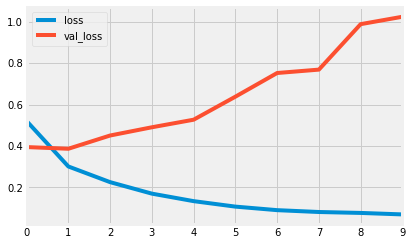

In [39]:
loss[["loss","val_loss"]].plot()

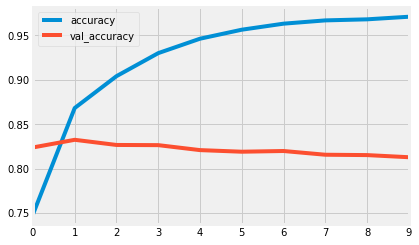

In [40]:
loss[["accuracy","val_accuracy"]].plot()

In [41]:
eval_loss,eval_accuracy=model.evaluate(test_data)

79/79 [==============================].3081 - accuracy: 0.92 - 0s 13ms/step - loss: 0.6819 - accuracy: 0.85 - 0s 17ms/step - loss: 0.8436 - accuracy: 0.83 - 0s 18ms/step - loss: 0.8284 - accuracy: 0.83 - 0s 20ms/step - loss: 0.8491 - accuracy: 0.82 - 0s 20ms/step - loss: 0.8698 - accuracy: 0.82 - 0s 20ms/step - loss: 0.9251 - accuracy: 0.80 - 0s 21ms/step - loss: 0.9335 - accuracy: 0.80 - 1s 21ms/step - loss: 0.9832 - accuracy: 0.80 - 1s 21ms/step - loss: 0.9918 - accuracy: 0.80 - 1s 21ms/step - loss: 0.9730 - accuracy: 0.81 - 1s 22ms/step - loss: 0.9677 - accuracy: 0.81 - 1s 22ms/step - loss: 0.9948 - accuracy: 0.81 - 1s 22ms/step - loss: 0.9793 - accuracy: 0.81 - 1s 22ms/step - loss: 0.9753 - accuracy: 0.81 - 1s 22ms/step - loss: 0.9751 - accuracy: 0.81 - 1s 22ms/step - loss: 0.9661 - accuracy: 0.81 - 1s 21ms/step - loss: 0.9853 - accuracy: 0.81 - 1s 21ms/step - loss: 0.9906 - accuracy: 0.81 - 1s 21ms/step - loss: 1.0038 - accuracy: 0.81 - 1s 21ms/step - loss: 1.0115 - accuracy: 0.81

In [42]:
print(f"eval loss is {eval_loss} , eval accuracy is {eval_accuracy*100} %")

eval loss is 1.0235435962677002 , eval accuracy is 81.27999901771545 %
